In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

sns.set_style('whitegrid')

In [2]:
# Import maximum demands per locality

demand = pd.read_csv('demand.csv')

demand = (demand
          .set_index(pd.to_datetime(demand['Date']))
          .drop('Date', axis = 1)
          )

In [3]:
# Import day-ahead market prices
dam = pd.read_csv('dam.csv')

dam['Date'] = pd.to_datetime(dam['Date'])

dam = (dam
       .set_index(dam['Date']) # pd.to_datetime(dam['Date'])
       .drop('Date', axis = 1)
       )

dam = dam.reset_index().rename(columns = {'Date': 'date_old'})
dam['date_new'] = dam['date_old'] - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

dam = dam.drop('date_old', axis = 1).rename(columns = {'date_new': 'Date'}).set_index('Date')

dam.columns = ['nyca_dam', 'nyc_dam', 'li_dam', 'gj_dam']

In [4]:
# Import fuel prices
fuels = pd.read_csv('fuels.csv')
fuels = (fuels
         .set_index(pd.to_datetime(fuels['Date']))
         .drop('Date', axis = 1)
        )

In [5]:
# Import capacity prices
cap = pd.read_csv('cap.csv')
cap = (cap
       .set_index(pd.to_datetime(cap['Date'], format = '%b-%y'))
       .drop('Date', axis = 1)
       )
cap.columns = ['nyca_icap', 'gj_icap', 'nyc_icap', 'li_icap']

#cap.plot()

In [6]:
# Generation capacities

locs = ['GJ', 'LI', 'NYC']

gen = {}

for loc in locs:
    gen[loc] = pd.read_csv(f'../data\Generating_Capacity_{loc}_11-23.csv')
    gen[loc] = (gen[loc]
                .set_index(pd.to_datetime(gen[loc]['Date']))
                .drop('Date', axis = 1))
    
    oidx = gen[loc].index
    nidx = pd.date_range(oidx.min(), oidx.max(), freq = 'M')
    gen[loc] = gen[loc].reindex(oidx.union(nidx)).interpolate('index').reindex(nidx).shift(periods=-1, freq="m").shift(periods=1, freq="d")

gen['NYCA'] = pd.read_csv('../data\Generating_Capacity_NYCA_04-23.csv')
gen['NYCA'] = (gen['NYCA']
               .set_index(pd.to_datetime(gen['NYCA']['Date']))
               .drop('Date', axis = 1)
               )

oidx = gen['NYCA'].index
nidx = pd.date_range(oidx.min(), oidx.max(), freq = 'M')
gen['NYCA'] = gen['NYCA'].reindex(oidx.union(nidx)).interpolate('index').reindex(nidx).shift(periods=-1, freq="m").shift(periods=1, freq="d")

In [7]:
# Create oversupply features
locs = ['GJ', 'LI', 'NYC', 'NYCA']
oversupply = {}
for loc in locs:
    oversupply[loc] = gen[loc].join(demand)
    oversupply[loc][f'Over_{loc}'] =  oversupply[loc][f'Sum ({loc})'] - oversupply[loc][loc]

In [8]:
# Calculate sum of generating capacity excluding natural gas power plants
locs = ['GJ', 'LI', 'NYC', 'NYCA']
for loc in locs:
    gen[loc]['Sum_woGas (' + str(loc) + ')'] = gen[loc]['Sum (' + str(loc) + ')']-gen[loc]['Gas (' + str(loc) + ')']

In [19]:
nyca_icap_1 = pd.DataFrame()
nyca_icap_1['ICAP-1'] = cap['nyca_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

nyca_dam_1 = pd.DataFrame()
nyca_dam_1['DAM-1'] = dam['nyca_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

nyc_icap_1 = pd.DataFrame()
nyc_icap_1['ICAP-1'] = cap['nyc_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

nyc_dam_1 = pd.DataFrame()
nyc_dam_1['DAM-1'] = dam['nyc_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

gj_icap_1 = pd.DataFrame()
gj_icap_1['ICAP-1'] = cap['gj_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

gj_dam_1 = pd.DataFrame()
gj_dam_1['DAM-1'] = dam['gj_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

li_icap_1 = pd.DataFrame()
li_icap_1['ICAP-1'] = cap['li_icap'].shift(periods=12, freq="m").shift(periods=1, freq="d")

li_dam_1 = pd.DataFrame()
li_dam_1['DAM-1'] = dam['li_dam'].shift(periods=12, freq="m").shift(periods=1, freq="d")

In [20]:
nyca_icap_2 = pd.DataFrame()
nyca_icap_2['ICAP-2'] = cap['nyca_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

nyca_dam_2 = pd.DataFrame()
nyca_dam_2['DAM-2'] = dam['nyca_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

nyc_icap_2 = pd.DataFrame()
nyc_icap_2['ICAP-2'] = cap['nyc_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

nyc_dam_2 = pd.DataFrame()
nyc_dam_2['DAM-2'] = dam['nyc_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

gj_icap_2 = pd.DataFrame()
gj_icap_2['ICAP-2'] = cap['gj_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

gj_dam_2 = pd.DataFrame()
gj_dam_2['DAM-2'] = dam['gj_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

li_icap_2 = pd.DataFrame()
li_icap_2['ICAP-2'] = cap['li_icap'].shift(periods=24, freq="m").shift(periods=1, freq="d")

li_dam_2 = pd.DataFrame()
li_dam_2['DAM-2'] = dam['li_dam'].shift(periods=24, freq="m").shift(periods=1, freq="d")

In [21]:
nyca_icap_3 = pd.DataFrame()
nyca_icap_3['ICAP-3'] = cap['nyca_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

nyca_dam_3 = pd.DataFrame()
nyca_dam_3['DAM-3'] = dam['nyca_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

nyc_icap_3 = pd.DataFrame()
nyc_icap_3['ICAP-3'] = cap['nyc_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

nyc_dam_3 = pd.DataFrame()
nyc_dam_3['DAM-3'] = dam['nyc_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

gj_icap_3 = pd.DataFrame()
gj_icap_3['ICAP-3'] = cap['gj_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

gj_dam_3 = pd.DataFrame()
gj_dam_3['DAM-3'] = dam['gj_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

li_icap_3 = pd.DataFrame()
li_icap_3['ICAP-3'] = cap['li_icap'].shift(periods=36, freq="m").shift(periods=1, freq="d")

li_dam_3 = pd.DataFrame()
li_dam_3['DAM-3'] = dam['li_dam'].shift(periods=36, freq="m").shift(periods=1, freq="d")

In [22]:
nyca_icap_4 = pd.DataFrame()
nyca_icap_4['ICAP-4'] = cap['nyca_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

nyca_dam_4 = pd.DataFrame()
nyca_dam_4['DAM-4'] = dam['nyca_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

nyc_icap_4 = pd.DataFrame()
nyc_icap_4['ICAP-4'] = cap['nyc_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

nyc_dam_4 = pd.DataFrame()
nyc_dam_4['DAM-4'] = dam['nyc_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

gj_icap_4 = pd.DataFrame()
gj_icap_4['ICAP-4'] = cap['gj_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

gj_dam_4 = pd.DataFrame()
gj_dam_4['DAM-4'] = dam['gj_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

li_icap_4 = pd.DataFrame()
li_icap_4['ICAP-4'] = cap['li_icap'].shift(periods=48, freq="m").shift(periods=1, freq="d")

li_dam_4 = pd.DataFrame()
li_dam_4['DAM-4'] = dam['li_dam'].shift(periods=48, freq="m").shift(periods=1, freq="d")

In [23]:
nyca_reg = (oversupply['NYCA']
            .join(cap)
            #.join(fuels)
            .join(dam)
            .join(nyca_icap_1)
            .join(nyca_icap_2)
            .join(nyca_icap_3)
            .join(nyca_icap_4)
            .join(nyca_dam_1)
            .join(nyca_dam_2)
            .join(nyca_dam_3)
            .join(nyca_dam_4)
            .dropna(axis = 0)
           )

In [24]:
nyc_reg = (oversupply['NYC']
            .join(cap)
            #.join(fuels)
            .join(dam)
            .join(nyc_icap_1)
            .join(nyc_icap_2)
            .join(nyc_icap_3)
            .join(nyc_icap_4)
            .join(nyc_dam_1)
            .join(nyc_dam_2)
            .join(nyc_dam_3)
            .join(nyc_dam_4)
            .dropna(axis = 0)
            )

In [25]:
gj_reg = (oversupply['GJ']
            .join(cap)
            #.join(fuels)
            .join(dam)
            .join(gj_icap_1)
            .join(gj_icap_2)
            .join(gj_icap_3)
            .join(gj_icap_4)
            .join(gj_dam_1)
            .join(gj_dam_2)
            .join(gj_dam_3)
            .join(gj_dam_4)
            .dropna(axis = 0)
            )

In [26]:
li_reg = (oversupply['LI']
            .join(cap)
            .join(fuels)
            .join(dam)
            .join(li_icap_1)
            .join(li_icap_2)
            .join(li_icap_3)
            .join(li_icap_4)
            .join(li_dam_1)
            .join(li_dam_2)
            .join(li_dam_3)
            .join(li_dam_4)
            .dropna(axis = 0)
            )

In [27]:
nyca_df = nyca_reg[['Gas (NYCA)', 
                    #'Coal (NYCA)',
                    #'Oil (NYCA)', 
                    #'Renewables (NYCA)', 
                    #'Others (NYCA)',
                    #'Sum (NYCA)',
                    #'Sum_woGas (NYCA)',
                    'nyca_icap',
                    #'natural gas', 
                    'nyca_dam', 
                    #'Cleared Above NYCA (%)', 
                    #'UCAP NYCA (MW)',
                    'ICAP-1', 
                    'ICAP-2', 
                    'ICAP-3', 
                    'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 
                    'DAM-3', 
                    'DAM-4'
                    ]]

#nyca_df['t'] = np.arange(1, len(nyca_df['Gas (NYCA)'])+1)

<Axes: >

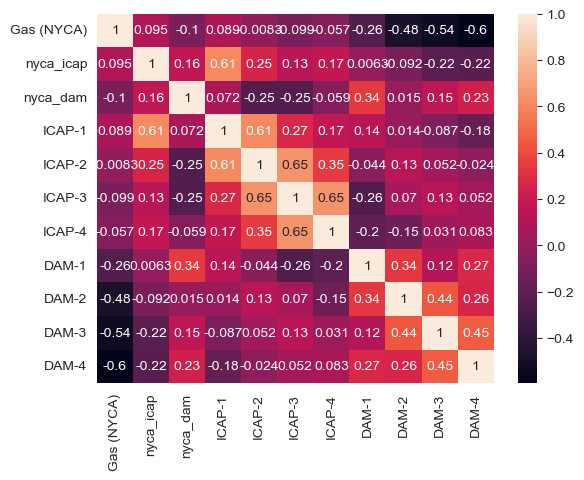

In [28]:
sns.heatmap(nyca_df.corr(), annot = True)

In [29]:
x = nyca_df.loc[:, nyca_df.columns != 'Gas (NYCA)']
y = nyca_df['Gas (NYCA)']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Gas (NYCA)   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     15.86
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           6.80e-19
Time:                        11:54:13   Log-Likelihood:                -1283.5
No. Observations:                 154   AIC:                             2589.
Df Residuals:                     143   BIC:                             2622.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.57e+04    331.117     77.623      0.0

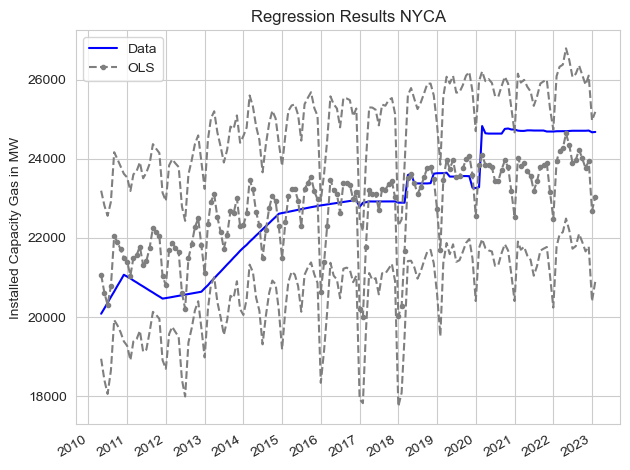

In [30]:
res = model
x = nyca_df.index
y_true = nyca_df['Gas (NYCA)']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b-', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(22000, 24500)
ax.set_title('Regression Results NYCA')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [31]:
nyc_reg.columns

Index(['Gas (NYC)', 'Coal (NYC)', 'Oil (NYC)', 'Renewables (NYC)',
       'Others (NYC)', 'Sum (NYC)', 'NYC', 'LI', 'GJ', 'NYCA', 'Over_NYC',
       'nyca_icap', 'gj_icap', 'nyc_icap', 'li_icap', 'nyca_dam', 'nyc_dam',
       'li_dam', 'gj_dam', 'ICAP-1', 'ICAP-2', 'ICAP-3', 'ICAP-4', 'DAM-1',
       'DAM-2', 'DAM-3', 'DAM-4'],
      dtype='object')

In [32]:
nyc_df = nyc_reg[['Gas (NYC)', 
                    #'Coal (NYC)',
                    # 'Oil (NYC)', 
                    #'Renewables (NYC)', 
                    #'Others (NYC)',
                    #'Sum (NYC)',
                    #'Sum_woGas (NYC)',
                    'nyc_icap',
                    #'natural gas', 
                    'nyc_dam', 
                    #'Cleared Above NYC (%)', 
                    #'UCAP NYC (MW)',
                    'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

<Axes: >

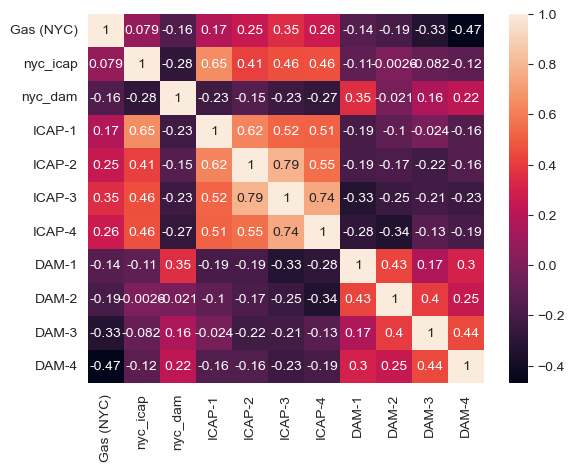

In [33]:
sns.heatmap(nyc_df.corr(), annot = True)

In [34]:
x = nyc_df.loc[:, nyc_df.columns != 'Gas (NYC)']
y = nyc_df['Gas (NYC)']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Gas (NYC)   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     6.200
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           9.33e-08
Time:                        11:54:16   Log-Likelihood:                -1074.2
No. Observations:                 146   AIC:                             2170.
Df Residuals:                     135   BIC:                             2203.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8973.1091    155.128     57.843      0.0

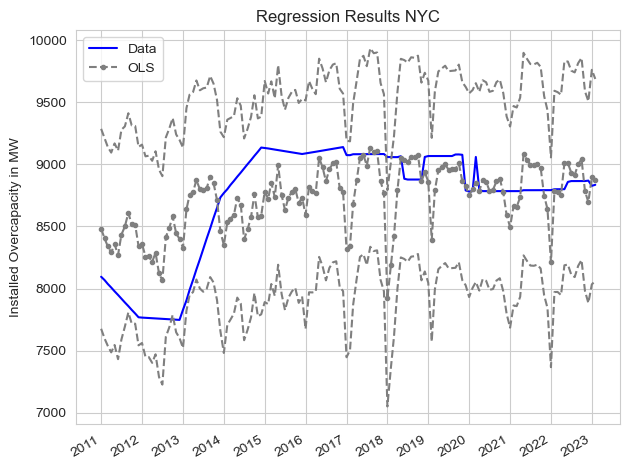

In [36]:
res = model
x = nyc_df.index
y_true = nyc_df['Gas (NYC)']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b-', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(8500, 9500)
ax.set_title('Regression Results NYC')
ax.set_ylabel('Installed Overcapacity in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [37]:
gj_df = gj_reg[['Gas (GJ)', 
                    #'Coal (GJ)',
                    # 'Oil (GJ)', 
                    #'Renewables (GJ)', 
                    #'Others (GJ)',
                    #'Sum (GJ)',
                    #'Sum_woGas (GJ)',
                    'gj_icap',
                    #'natural gas', 
                    'gj_dam', 
                    #'Cleared Above GJ (%)', 
                    #'UCAP GJ (MW)',
                    'ICAP-1', 
                    'ICAP-2', 
                    'ICAP-3', 
                    'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 
                    'DAM-3', 'DAM-4'
                    ]]

<Axes: >

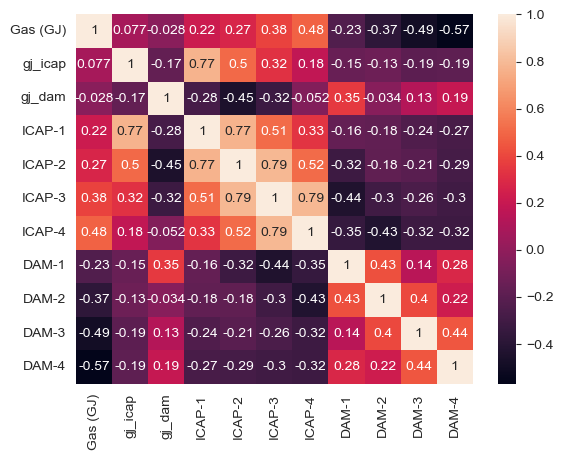

In [38]:
sns.heatmap(gj_df.corr(), annot = True)

In [39]:
x = gj_df.loc[:, gj_df.columns != 'Gas (GJ)']
y = gj_df['Gas (GJ)']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Gas (GJ)   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     13.27
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           5.49e-16
Time:                        11:55:31   Log-Likelihood:                -1196.9
No. Observations:                 146   AIC:                             2416.
Df Residuals:                     135   BIC:                             2449.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.484e+04    361.817     41.019      0.0

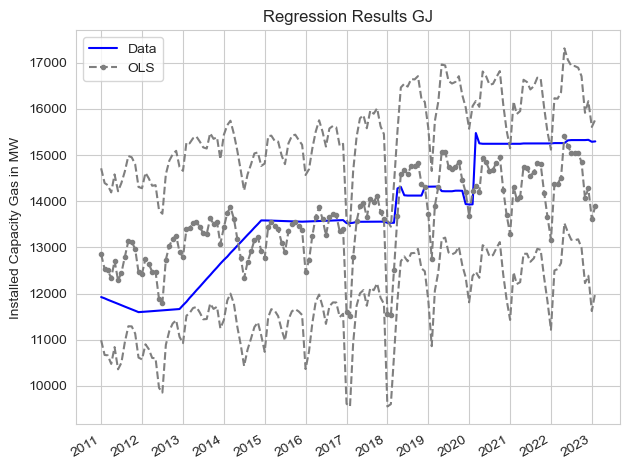

In [40]:
res = model
x = gj_df.index
y_true = gj_df['Gas (GJ)']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b-', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(12500, 15000)
ax.set_title('Regression Results GJ')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()

In [41]:
li_df = li_reg[['Gas (LI)', 
                    #'Coal (LI)',
                    # 'Oil (LI)', 
                    #'Renewables (LI)', 
                    #'Others (LI)',
                    #'Sum (LI)',
                    #'Sum_woGas (LI)',
                    'li_icap',
                    #'natural gas', 
                    'li_dam', 
                    #'Cleared Above LI (%)', 
                    #'UCAP LI (MW)',
                    'ICAP-1', 
                    'ICAP-2', 'ICAP-3', 'ICAP-4',
                    'DAM-1', 
                    'DAM-2', 'DAM-3', 'DAM-4'
                    ]]

<Axes: >

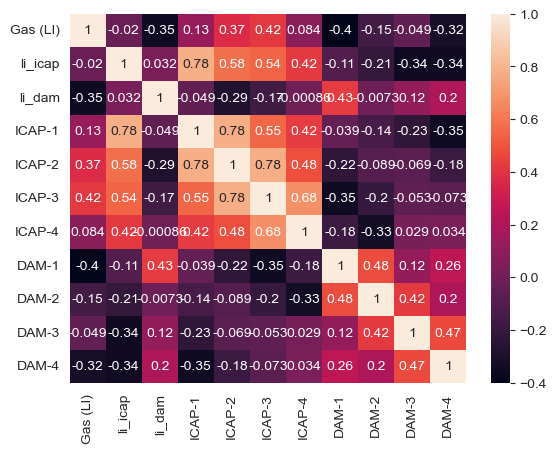

In [42]:
sns.heatmap(li_df.corr(), annot = True)

In [43]:
x = li_df.loc[:, li_df.columns != 'Gas (LI)']
y = li_df['Gas (LI)']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Gas (LI)   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     14.29
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           5.02e-17
Time:                        11:55:33   Log-Likelihood:                -760.71
No. Observations:                 146   AIC:                             1543.
Df Residuals:                     135   BIC:                             1576.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4117.7468     15.842    259.926      0.0

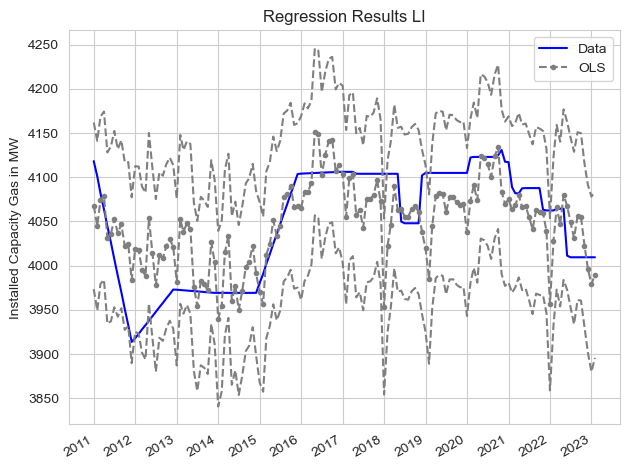

In [45]:
res = model
x = li_df.index
y_true = li_df['Gas (LI)']
y = predictions

prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots()
#ax.plot(x, y, 'o', label="Estimated")
ax.plot(x, y_true, 'b-', label="Data")
ax.plot(x, res.fittedvalues, color='tab:gray', marker='.', linestyle='--', label="OLS") #--.
ax.plot(x, iv_u, color='tab:gray', linestyle='--')
ax.plot(x, iv_l, color='tab:gray', linestyle='--')
ax.legend(loc='best')
#ax.set_ylim(3900, 4200)
ax.set_title('Regression Results LI')
ax.set_ylabel('Installed Capacity Gas in MW')

formatter = mdates.DateFormatter("%Y") # formatter of the date
locator = mdates.YearLocator() # where to put the labels
ax.xaxis.set_major_formatter(formatter) # calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) # calling the locator for the x-axis
fig.autofmt_xdate() # tilt the date labels
plt.tight_layout()

plt.show()